In [181]:
!pip install tensorflow

In [182]:
!pip install tensorflow-hub



In [183]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [184]:
model_url = "https://tfhub.dev/google/movenet/singlepose/lightning/4"
model = hub.load(model_url)

skeleton = [
    (0, 1), (0, 2), (1, 3), (2, 4),  # Head and shoulders
    (0, 5), (0, 6), (5, 6),          # Upper torso
    (5, 7), (7, 9), (6, 8), (8, 10), # Arms
    (5, 11), (6, 12),                # Torso to hips
    (11, 13), (13, 15),              # Left leg
    (12, 14), (14, 16)               # Right leg
]

def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (192, 192))  # Resize to model's expected input size
    return image

In [185]:

def preprocess_image(image):
    input_image = tf.image.convert_image_dtype(image, dtype=tf.uint8)  # Convert to uint8
    input_image = tf.expand_dims(input_image, axis=0)  # Add batch dimension
    input_image = tf.cast(input_image, dtype=tf.int32)  # Cast to int32
    return input_image


In [186]:

def run_posenet(model, input_image):
  
    movenet = model.signatures['serving_default']
    outputs = movenet(input_image)
    
    # Extract keypoints from the output tensor
    keypoints = outputs['output_0'][0]  # Get keypoints from output
    return keypoints

In [187]:
def draw_keypoints_and_skeleton(image, keypoints, threshold=0.2):
    height, width, _ = image.shape

    # Reshape the keypoints tensor to (17, 3)
    keypoints = tf.reshape(keypoints, (17, 3))

    # Initialize the plot
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    
    # Plot keypoints
    for keypoint in keypoints:
        y, x, confidence = keypoint.numpy()
        if confidence > threshold:
            plt.scatter(x * width, y * height, c='red', s=50)  # Draw keypoints

    # Plot skeleton
    for joint1, joint2 in skeleton:
        y1, x1, c1 = keypoints[joint1].numpy()
        y2, x2, c2 = keypoints[joint2].numpy()

        if c1 > threshold and c2 > threshold:
            plt.plot([x1 * width, x2 * width], [y1 * height, y2 * height], 'green', linewidth=2)  # Connect keypoints

    plt.axis('off')
    plt.show()


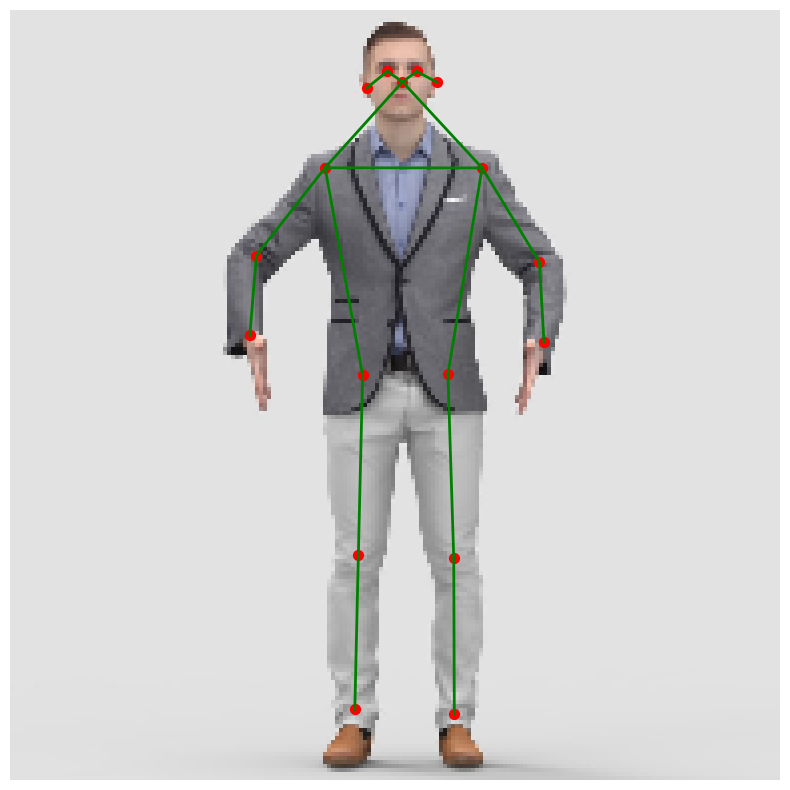

In [188]:
image_path = "Desktop/Fall/human-pose-estimation-opencv-master/image.jpg"  # Replace with your image path
image = load_image(image_path)
input_image = preprocess_image(image)
keypoints = run_posenet(model, input_image)
draw_keypoints_and_skeleton(image, keypoints)

In [189]:
import os
import pandas as pd

# Process images in labeled subfolders and save keypoints to Excel
def process_labeled_images_to_excel(input_folder, output_excel, threshold=0.2):
    data = []  # To store keypoint coordinates for each image

    # Check if the input folder exists
    if not os.path.exists(input_folder):
        print(f"Folder '{input_folder}' does not exist.")
        return

    # Iterate through the labeled subfolders (e.g., 'Sitting', 'Standing', 'Lying Down')
    for label in os.listdir(input_folder):
        label_path = os.path.join(input_folder, label)

        # Check if it's a directory
        if not os.path.isdir(label_path):
            continue

        print(f"\nProcessing label: {label}")  # Debug: Show current label

        # Iterate through images in the current label folder
        for img_name in os.listdir(label_path):
            img_path = os.path.join(label_path, img_name)

            # Check if the file is an image
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                print(f"Processing image: {img_name}")  # Debug: Show current image

                img = cv2.imread(img_path)

                if img is None:
                    print(f"Could not read {img_name}. Skipping...")
                    continue

                # Resize and preprocess the image
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img_rgb, (192, 192))
                input_image = preprocess_image(img_resized)

                # Get pose estimation for the current image
                keypoints = run_posenet(model, input_image)

                # Flatten keypoints and prepare data for saving
                keypoints = tf.reshape(keypoints, (17, 3)).numpy()
                img_data = {'Image': img_name, 'Label': label}

                # Add keypoints to the dictionary without setting any to None
                for i, (y, x, confidence) in enumerate(keypoints):
                    img_data[f"Keypoint_{i}_x"] = x
                    img_data[f"Keypoint_{i}_y"] = y
                    img_data[f"Keypoint_{i}_confidence"] = confidence

                print(f"Keypoints processed for {img_name}")  # Debug: Show successful processing
                data.append(img_data)

    # If no data was added, print a message
    if not data:
        print("No keypoints detected or no images processed.")
        return

    # Convert the data to a DataFrame
    df = pd.DataFrame(data)

    # Debug: Show sample data collected before exporting
    print("\nSample Data Collected:", df.head(2))  # Print first 2 rows to verify data collection

    # Save the DataFrame to an Excel file
    df.to_excel(output_excel, index=False)
    print(f"\nKeypoints saved to {output_excel}")

# Set the input folder and output file paths
input_folder = "Desktop/Fall Detection"  # Your specified folder path
output_excel = "labeled_fall_detection_keypoints.xlsx"

# Process images and save keypoints to Excel
process_labeled_images_to_excel(input_folder, output_excel, threshold=0.2)



Processing label: Lying Down
Processing image: 101_jpg.rf.6e402620b877103d87cc23f963d32e06.jpg
Keypoints processed for 101_jpg.rf.6e402620b877103d87cc23f963d32e06.jpg
Processing image: 101_jpg.rf.effd735d180e4e55758f8faa8c7aff77.jpg
Keypoints processed for 101_jpg.rf.effd735d180e4e55758f8faa8c7aff77.jpg
Processing image: 101_jpg.rf.f9859f24b63e129eb973fe56aeadeea0.jpg
Keypoints processed for 101_jpg.rf.f9859f24b63e129eb973fe56aeadeea0.jpg
Processing image: 102_jpg.rf.3e87c3d3b2d18836e6806b2917ae8b83.jpg
Keypoints processed for 102_jpg.rf.3e87c3d3b2d18836e6806b2917ae8b83.jpg
Processing image: 102_jpg.rf.5c12c7f157d24ba5cf35219cfb975187.jpg
Keypoints processed for 102_jpg.rf.5c12c7f157d24ba5cf35219cfb975187.jpg
Processing image: 102_jpg.rf.b20faac6c031f71dfc0f13cb6f20f949.jpg
Keypoints processed for 102_jpg.rf.b20faac6c031f71dfc0f13cb6f20f949.jpg
Processing image: 104_jpg.rf.41092f34540c0bd4a64d0169f3a77e83.jpg
Keypoints processed for 104_jpg.rf.41092f34540c0bd4a64d0169f3a77e83.jpg
Proc

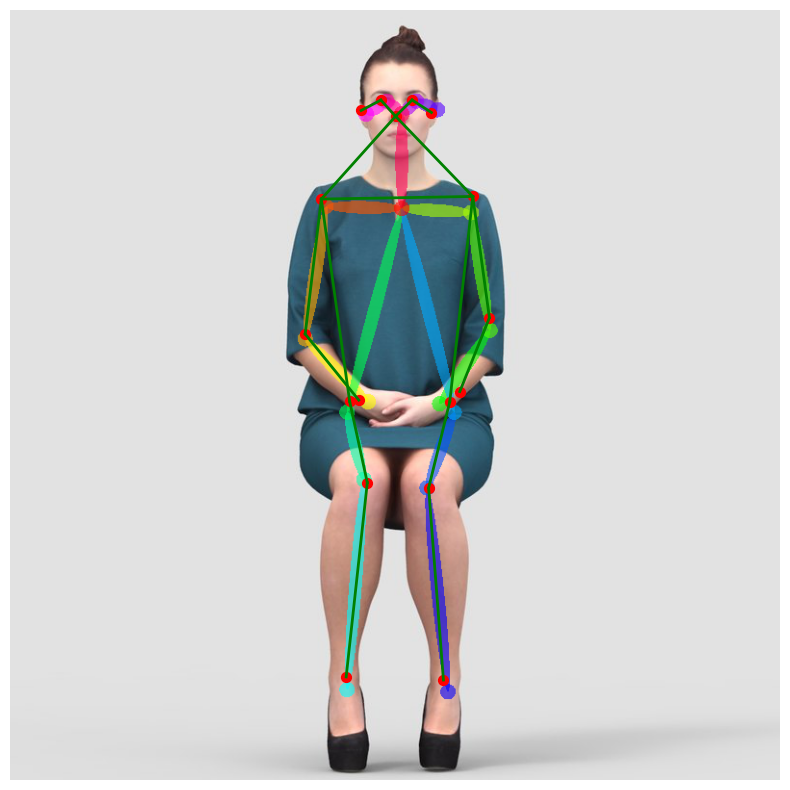

In [190]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# Skeleton definition (pairs of keypoints to connect)
skeleton = [
    (0, 1), (0, 2), (1, 3), (2, 4),  # Head and shoulders
    (0, 5), (0, 6), (5, 6),          # Upper torso
    (5, 7), (7, 9), (6, 8), (8, 10), # Arms
    (5, 11), (6, 12),                # Torso to hips
    (11, 13), (13, 15),              # Left leg
    (12, 14), (14, 16)               # Right leg
]

# Function to load image and keypoints from Excel
def load_keypoints_from_excel(excel_file, image_name):
    # Read the Excel file
    df = pd.read_excel(excel_file)
    
    # Find the row with the specified image name
    row = df[df['Image'] == image_name]

    if row.empty:
        print(f"Image '{image_name}' not found in the Excel file.")
        return None, None

    # Extract keypoints (x, y, confidence) from the row
    keypoints = []
    for i in range(17):
        x = row[f'Keypoint_{i}_x'].values[0]
        y = row[f'Keypoint_{i}_y'].values[0]
        confidence = row[f'Keypoint_{i}_confidence'].values[0]
        keypoints.append([y, x, confidence])

    return keypoints

# Function to draw skeleton on an image using Matplotlib
def draw_skeleton_on_image(image_path, keypoints, threshold=0.2):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    height, width, _ = image.shape

    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Plot keypoints
    for i, (y, x, confidence) in enumerate(keypoints):
        if confidence > threshold:
            plt.scatter(x * width, y * height, c='red', s=50)  # Draw keypoint

    # Plot skeleton
    for joint1, joint2 in skeleton:
        y1, x1, c1 = keypoints[joint1]
        y2, x2, c2 = keypoints[joint2]

        if c1 > threshold and c2 > threshold:
            plt.plot([x1 * width, x2 * width], [y1 * height, y2 * height], 'green', linewidth=2)  # Connect keypoints

    plt.axis('off')
    plt.show()

# Example usage
excel_file = "labeled_fall_detection_keypoints.xlsx"  # Your collected coordinates file
image_name = "sit_0000003_r_.png"  # Replace with the name of the image to visualize
image_path = "Desktop/Fall Detection/Sitting/sit_0000003_r_.png"  # Path to the specific image

# Load keypoints from Excel
keypoints = load_keypoints_from_excel(excel_file, image_name)

if keypoints:
    draw_skeleton_on_image(image_path, keypoints)


# **Pre Parameter Tuning**

# **Random Forest**

Training data size: 432
Validation data size: 93
Testing data size: 93

Validation Accuracy: 81.72%
Testing Accuracy: 73.12%

Classification Report (Testing):
              precision    recall  f1-score   support

  Lying Down       0.86      0.79      0.83        39
     Sitting       0.68      0.78      0.72        32
    Standing       0.60      0.55      0.57        22

    accuracy                           0.73        93
   macro avg       0.71      0.71      0.71        93
weighted avg       0.74      0.73      0.73        93



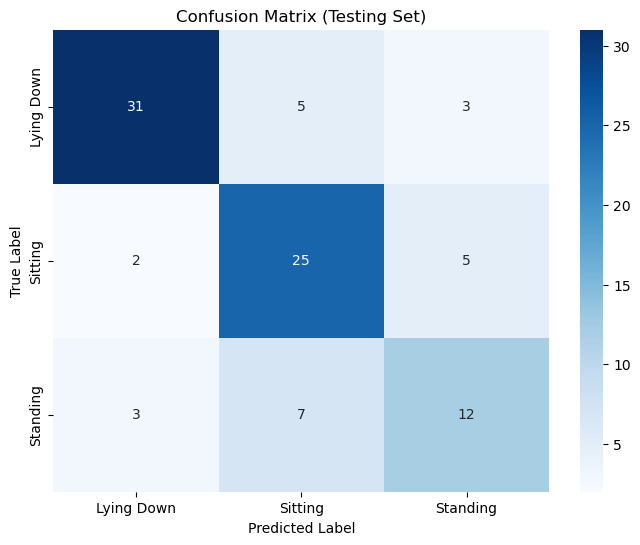

In [191]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset (Assume keypoints have been saved to an Excel file)
data_path = "labeled_fall_detection_keypoints.xlsx"
df = pd.read_excel(data_path)

# Prepare the feature matrix (X) and target vector (y)
X = df.drop(columns=['Image', 'Label'])  # Drop non-feature columns
y = df['Label']  # Target variable

# Split the data: 70% training, 15% validation, 15% testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

# Check the sizes of the datasets
print(f"Training data size: {X_train.shape[0]}")
print(f"Validation data size: {X_val.shape[0]}")
print(f"Testing data size: {X_test.shape[0]}")

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the validation and testing sets
y_val_pred = rf_classifier.predict(X_val)
y_test_pred = rf_classifier.predict(X_test)

# Calculate accuracy on validation and testing sets
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print classification reports
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")
print("\nClassification Report (Testing):")
print(classification_report(y_test, y_test_pred))

# Plot confusion matrix for the test set
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Testing Set)')
plt.show()


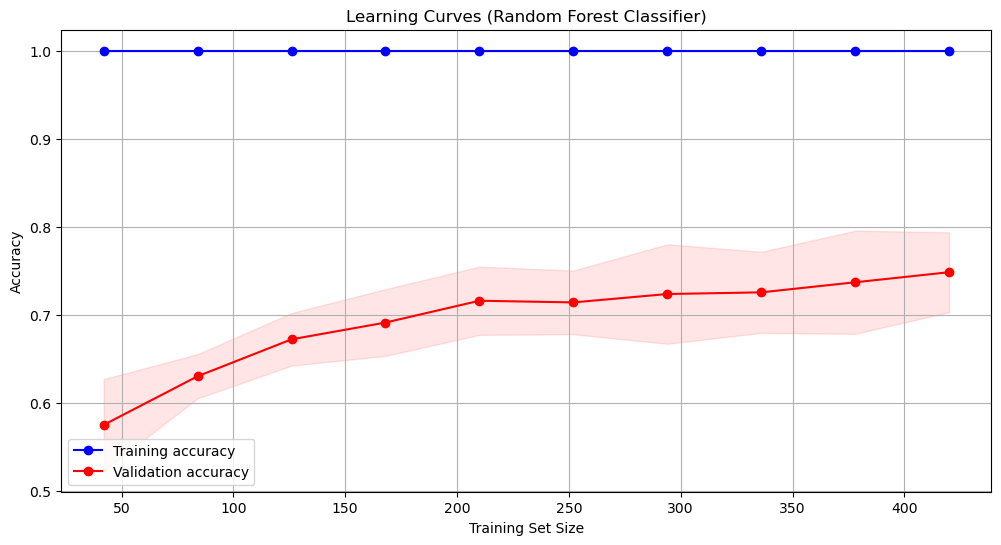

In [193]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curves(model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5):
    # Calculate learning curves
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, train_sizes=train_sizes, cv=cv, scoring='accuracy', n_jobs=-1, random_state=42
    )

    # Calculate mean and standard deviation for training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    # Plotting the learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='b', label='Training accuracy')
    plt.plot(train_sizes, val_scores_mean, 'o-', color='r', label='Validation accuracy')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='b')
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='r')

    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.title('Learning Curves (Random Forest Classifier)')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Prepare the complete dataset (combining training and validation sets)
X_combined = pd.concat([X_train, X_val])
y_combined = pd.concat([y_train, y_val])

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Plot the learning curves
plot_learning_curves(rf_classifier, X_combined, y_combined, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)


Predicted Pose: Lying Down


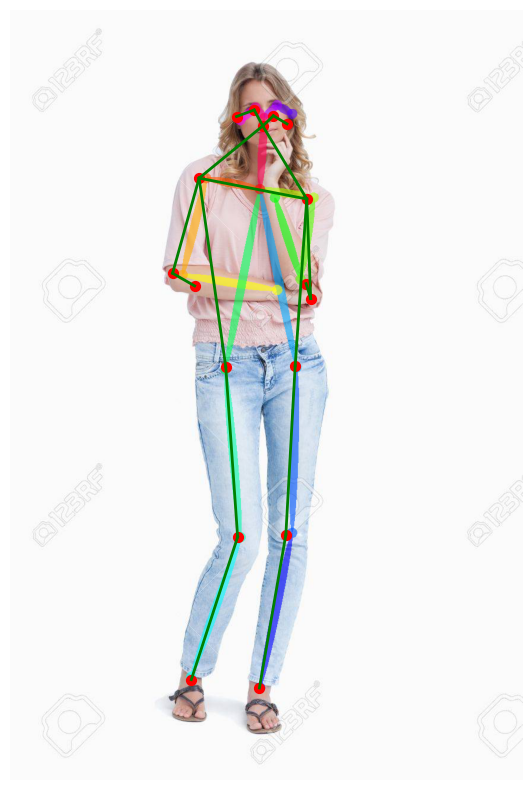

Final Prediction for 'Desktop/Fall Detection/Standing/stand_0000003_r_.png': Lying Down


In [194]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Function to preprocess the uploaded image
def preprocess_uploaded_image(image_path):
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not read image from {image_path}. Please check the file path.")
        return None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (192, 192))  # Resize to model input size
    input_image = tf.image.convert_image_dtype(img_resized, dtype=tf.uint8)
    input_image = tf.expand_dims(input_image, axis=0)  # Add batch dimension
    input_image = tf.cast(input_image, dtype=tf.int32)  # Cast to int32
    return img_rgb, input_image

# Function to extract keypoints using PoseNet
def get_keypoints_posenet(input_image):
    movenet = model.signatures['serving_default']
    outputs = movenet(input_image)

    # Extract keypoints from the output tensor
    keypoints = outputs['output_0'][0].numpy().reshape(17, 3)  # Reshape to (17, 3)
    return keypoints

# Function to add the same features as used during training (to ensure 51 features)
def add_consistent_features(keypoints):
    # Flatten keypoints (34 features: 17 x, 17 y)
    flattened_features = keypoints[:, :2].flatten().tolist()

    # Calculate distances between adjacent keypoints for 17 additional features
    additional_features = []
    for i in range(1, len(keypoints)):
        distance = np.sqrt((keypoints[i, 0] - keypoints[i-1, 0])**2 + (keypoints[i, 1] - keypoints[i-1, 1])**2)
        additional_features.append(distance)

    # Combine flattened features and additional features
    features = flattened_features + additional_features

    # Ensure the feature vector has exactly 51 features
    if len(features) > 51:
        features = features[:51]
    elif len(features) < 51:
        features.extend([0] * (51 - len(features)))  # Pad with zeros if needed

    return features

# Function to predict pose from the uploaded image
def predict_pose_from_uploaded_image(image_path):
    img_rgb, input_image = preprocess_uploaded_image(image_path)

    if img_rgb is None:
        return

    # Get keypoints using PoseNet
    keypoints = get_keypoints_posenet(input_image)

    # Create a consistent feature vector with 51 features
    feature_vector = add_consistent_features(keypoints)

    # Reshape the feature vector to match the model input
    feature_vector = np.array(feature_vector).reshape(1, -1)

    # Check if the feature vector matches the model's expected input size
    if feature_vector.shape[1] != rf_classifier.n_features_in_:
        print(f"Error: Feature vector has {feature_vector.shape[1]} features, but model expects {rf_classifier.n_features_in_} features.")
        return

    # Predict the pose using the trained Random Forest model
    prediction = rf_classifier.predict(feature_vector)[0]
    print(f"Predicted Pose: {prediction}")

    # Draw the skeleton on the image
    draw_skeleton_on_image(img_rgb, keypoints)
    return prediction

# Function to draw skeleton on the image
def draw_skeleton_on_image(image, keypoints, threshold=0.2):
    height, width, _ = image.shape

    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Define the skeleton structure
    skeleton = [
        (0, 1), (0, 2), (1, 3), (2, 4),  # Head and shoulders
        (0, 5), (0, 6), (5, 6),          # Upper torso
        (5, 7), (7, 9), (6, 8), (8, 10), # Arms
        (5, 11), (6, 12),                # Torso to hips
        (11, 13), (13, 15),              # Left leg
        (12, 14), (14, 16)               # Right leg
    ]

    # Plot keypoints
    for i, (y, x, confidence) in enumerate(keypoints):
        if confidence > threshold:
            plt.scatter(x * width, y * height, c='red', s=50)  # Draw keypoint

    # Plot skeleton
    for joint1, joint2 in skeleton:
        y1, x1, c1 = keypoints[joint1]
        y2, x2, c2 = keypoints[joint2]

        if c1 > threshold and c2 > threshold:
            plt.plot([x1 * width, x2 * width], [y1 * height, y2 * height], 'green', linewidth=2)  # Connect keypoints

    plt.axis('off')
    plt.show()

# Load the dataset and train the Random Forest model
data_path = "labeled_fall_detection_keypoints.xlsx"
df = pd.read_excel(data_path)

# Prepare feature matrix (X) and labels (y)
X = df.drop(columns=['Image', 'Label']).values  # Drop non-feature columns
y = df['Label'].values  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest without GridSearch
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Test with the uploaded image file
image_path = "Desktop/Fall Detection/Standing/stand_0000003_r_.png"  # Replace with your test image path
predicted_pose = predict_pose_from_uploaded_image(image_path)
print(f"Final Prediction for '{image_path}': {predicted_pose}")


Predicted Pose: Lying Down


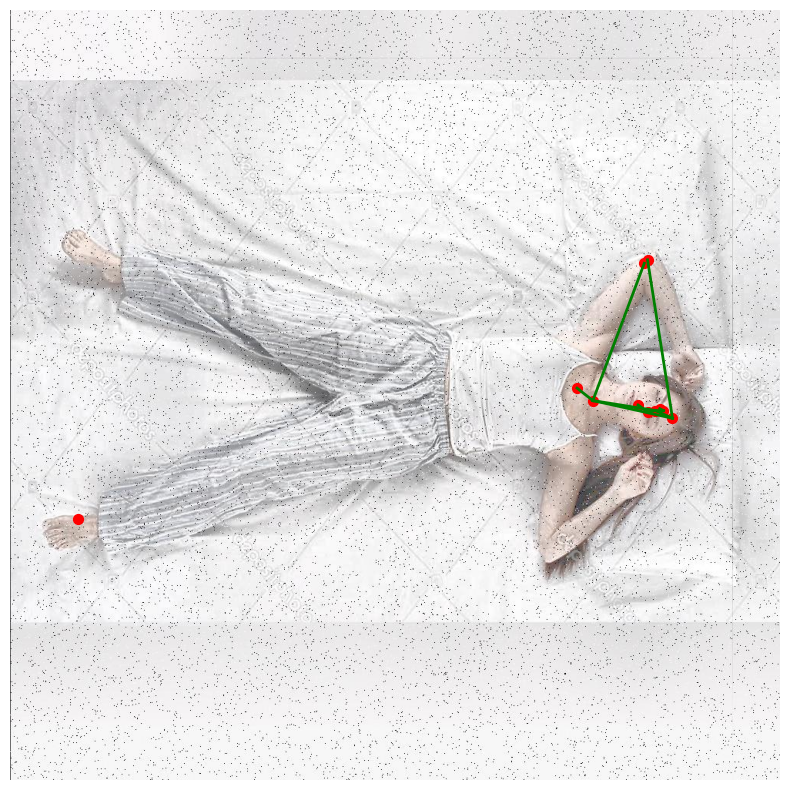

Final Prediction for 'Desktop/Fall Detection/Lying Down/57_jpg.rf.852af7a7db5efce5a701bf2e7d2f75d4.jpg': Lying Down


In [195]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Function to preprocess the uploaded image
def preprocess_uploaded_image(image_path):
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not read image from {image_path}. Please check the file path.")
        return None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (192, 192))  # Resize to model input size
    input_image = tf.image.convert_image_dtype(img_resized, dtype=tf.uint8)
    input_image = tf.expand_dims(input_image, axis=0)  # Add batch dimension
    input_image = tf.cast(input_image, dtype=tf.int32)  # Cast to int32
    return img_rgb, input_image

# Function to extract keypoints using PoseNet
def get_keypoints_posenet(input_image):
    movenet = model.signatures['serving_default']
    outputs = movenet(input_image)

    # Extract keypoints from the output tensor
    keypoints = outputs['output_0'][0].numpy().reshape(17, 3)  # Reshape to (17, 3)
    return keypoints

# Function to add the same features as used during training (to ensure 51 features)
def add_consistent_features(keypoints):
    # Flatten keypoints (34 features: 17 x, 17 y)
    flattened_features = keypoints[:, :2].flatten().tolist()

    # Calculate distances between adjacent keypoints for 17 additional features
    additional_features = []
    for i in range(1, len(keypoints)):
        distance = np.sqrt((keypoints[i, 0] - keypoints[i-1, 0])**2 + (keypoints[i, 1] - keypoints[i-1, 1])**2)
        additional_features.append(distance)

    # Combine flattened features and additional features
    features = flattened_features + additional_features

    # Ensure the feature vector has exactly 51 features
    if len(features) > 51:
        features = features[:51]
    elif len(features) < 51:
        features.extend([0] * (51 - len(features)))  # Pad with zeros if needed

    return features

# Function to predict pose from the uploaded image
def predict_pose_from_uploaded_image(image_path):
    img_rgb, input_image = preprocess_uploaded_image(image_path)

    if img_rgb is None:
        return

    # Get keypoints using PoseNet
    keypoints = get_keypoints_posenet(input_image)

    # Create a consistent feature vector with 51 features
    feature_vector = add_consistent_features(keypoints)

    # Reshape the feature vector to match the model input
    feature_vector = np.array(feature_vector).reshape(1, -1)

    # Check if the feature vector matches the model's expected input size
    if feature_vector.shape[1] != rf_classifier.n_features_in_:
        print(f"Error: Feature vector has {feature_vector.shape[1]} features, but model expects {rf_classifier.n_features_in_} features.")
        return

    # Predict the pose using the trained Random Forest model
    prediction = rf_classifier.predict(feature_vector)[0]
    print(f"Predicted Pose: {prediction}")

    # Draw the skeleton on the image
    draw_skeleton_on_image(img_rgb, keypoints)
    return prediction

# Function to draw skeleton on the image
def draw_skeleton_on_image(image, keypoints, threshold=0.2):
    height, width, _ = image.shape

    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Define the skeleton structure
    skeleton = [
        (0, 1), (0, 2), (1, 3), (2, 4),  # Head and shoulders
        (0, 5), (0, 6), (5, 6),          # Upper torso
        (5, 7), (7, 9), (6, 8), (8, 10), # Arms
        (5, 11), (6, 12),                # Torso to hips
        (11, 13), (13, 15),              # Left leg
        (12, 14), (14, 16)               # Right leg
    ]

    # Plot keypoints
    for i, (y, x, confidence) in enumerate(keypoints):
        if confidence > threshold:
            plt.scatter(x * width, y * height, c='red', s=50)  # Draw keypoint

    # Plot skeleton
    for joint1, joint2 in skeleton:
        y1, x1, c1 = keypoints[joint1]
        y2, x2, c2 = keypoints[joint2]

        if c1 > threshold and c2 > threshold:
            plt.plot([x1 * width, x2 * width], [y1 * height, y2 * height], 'green', linewidth=2)  # Connect keypoints

    plt.axis('off')
    plt.show()

# Load the dataset and train the Random Forest model
data_path = "labeled_fall_detection_keypoints.xlsx"
df = pd.read_excel(data_path)

# Prepare feature matrix (X) and labels (y)
X = df.drop(columns=['Image', 'Label']).values  # Drop non-feature columns
y = df['Label'].values  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest without GridSearch
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Test with the uploaded image file
image_path =  "Desktop/Fall Detection/Lying Down/57_jpg.rf.852af7a7db5efce5a701bf2e7d2f75d4.jpg" # Replace with your test image path
predicted_pose = predict_pose_from_uploaded_image(image_path)
print(f"Final Prediction for '{image_path}': {predicted_pose}")


Predicted Pose: Lying Down


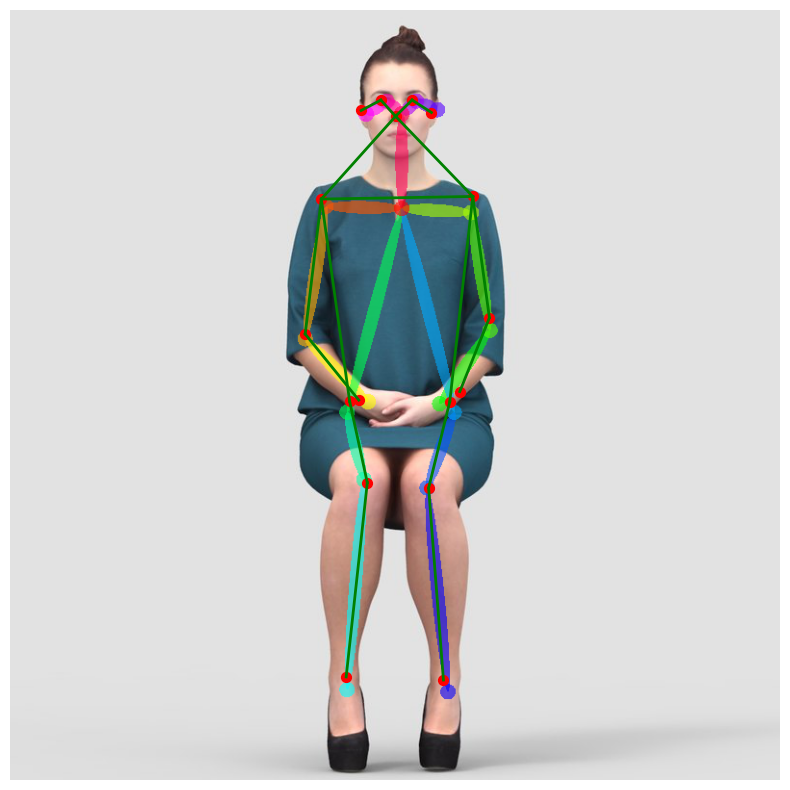

Final Prediction for 'Desktop/Fall Detection/Sitting/sit_0000003_r_.png': Lying Down


In [196]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Function to preprocess the uploaded image
def preprocess_uploaded_image(image_path):
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not read image from {image_path}. Please check the file path.")
        return None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (192, 192))  # Resize to model input size
    input_image = tf.image.convert_image_dtype(img_resized, dtype=tf.uint8)
    input_image = tf.expand_dims(input_image, axis=0)  # Add batch dimension
    input_image = tf.cast(input_image, dtype=tf.int32)  # Cast to int32
    return img_rgb, input_image

# Function to extract keypoints using PoseNet
def get_keypoints_posenet(input_image):
    movenet = model.signatures['serving_default']
    outputs = movenet(input_image)

    # Extract keypoints from the output tensor
    keypoints = outputs['output_0'][0].numpy().reshape(17, 3)  # Reshape to (17, 3)
    return keypoints

# Function to add the same features as used during training (to ensure 51 features)
def add_consistent_features(keypoints):
    # Flatten keypoints (34 features: 17 x, 17 y)
    flattened_features = keypoints[:, :2].flatten().tolist()

    # Calculate distances between adjacent keypoints for 17 additional features
    additional_features = []
    for i in range(1, len(keypoints)):
        distance = np.sqrt((keypoints[i, 0] - keypoints[i-1, 0])**2 + (keypoints[i, 1] - keypoints[i-1, 1])**2)
        additional_features.append(distance)

    # Combine flattened features and additional features
    features = flattened_features + additional_features

    # Ensure the feature vector has exactly 51 features
    if len(features) > 51:
        features = features[:51]
    elif len(features) < 51:
        features.extend([0] * (51 - len(features)))  # Pad with zeros if needed

    return features

# Function to predict pose from the uploaded image
def predict_pose_from_uploaded_image(image_path):
    img_rgb, input_image = preprocess_uploaded_image(image_path)

    if img_rgb is None:
        return

    # Get keypoints using PoseNet
    keypoints = get_keypoints_posenet(input_image)

    # Create a consistent feature vector with 51 features
    feature_vector = add_consistent_features(keypoints)

    # Reshape the feature vector to match the model input
    feature_vector = np.array(feature_vector).reshape(1, -1)

    # Check if the feature vector matches the model's expected input size
    if feature_vector.shape[1] != rf_classifier.n_features_in_:
        print(f"Error: Feature vector has {feature_vector.shape[1]} features, but model expects {rf_classifier.n_features_in_} features.")
        return

    # Predict the pose using the trained Random Forest model
    prediction = rf_classifier.predict(feature_vector)[0]
    print(f"Predicted Pose: {prediction}")

    # Draw the skeleton on the image
    draw_skeleton_on_image(img_rgb, keypoints)
    return prediction

# Function to draw skeleton on the image
def draw_skeleton_on_image(image, keypoints, threshold=0.2):
    height, width, _ = image.shape

    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Define the skeleton structure
    skeleton = [
        (0, 1), (0, 2), (1, 3), (2, 4),  # Head and shoulders
        (0, 5), (0, 6), (5, 6),          # Upper torso
        (5, 7), (7, 9), (6, 8), (8, 10), # Arms
        (5, 11), (6, 12),                # Torso to hips
        (11, 13), (13, 15),              # Left leg
        (12, 14), (14, 16)               # Right leg
    ]

    # Plot keypoints
    for i, (y, x, confidence) in enumerate(keypoints):
        if confidence > threshold:
            plt.scatter(x * width, y * height, c='red', s=50)  # Draw keypoint

    # Plot skeleton
    for joint1, joint2 in skeleton:
        y1, x1, c1 = keypoints[joint1]
        y2, x2, c2 = keypoints[joint2]

        if c1 > threshold and c2 > threshold:
            plt.plot([x1 * width, x2 * width], [y1 * height, y2 * height], 'green', linewidth=2)  # Connect keypoints

    plt.axis('off')
    plt.show()

# Load the dataset and train the Random Forest model
data_path = "labeled_fall_detection_keypoints.xlsx"
df = pd.read_excel(data_path)

# Prepare feature matrix (X) and labels (y)
X = df.drop(columns=['Image', 'Label']).values  # Drop non-feature columns
y = df['Label'].values  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest without GridSearch
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Test with the uploaded image file
image_path = "Desktop/Fall Detection/Sitting/sit_0000003_r_.png"  # Replace with your test image path
predicted_pose = predict_pose_from_uploaded_image(image_path)
print(f"Final Prediction for '{image_path}': {predicted_pose}")


# **Post Parameter Tuning**

Cross-Validation Accuracy: 79.44%

Test Set Accuracy: 0.8

Classification Report:
               precision    recall  f1-score   support

  Lying Down       0.91      0.88      0.89        57
    Standing       0.72      0.76      0.74        45
     Sitting       0.73      0.73      0.73        33

    accuracy                           0.80       135
   macro avg       0.79      0.79      0.79       135
weighted avg       0.80      0.80      0.80       135



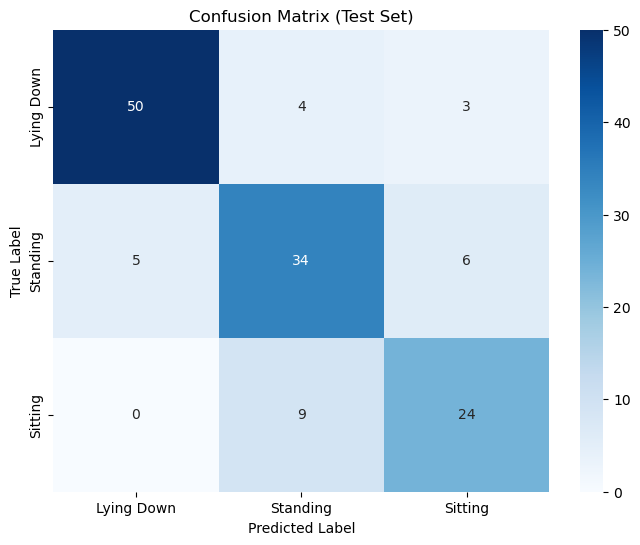

In [197]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to add distance features
def add_features(keypoints):
    features = []
    
    # Calculate distances between some keypoints
    def distance(p1, p2):
        return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

    # Distance between left and right shoulder (keypoints 5 and 6)
    features.append(distance(keypoints[5], keypoints[6]))
    
    # Distance between left hip and right hip (keypoints 11 and 12)
    features.append(distance(keypoints[11], keypoints[12]))

    return features

# Load the coordinate file
file_path = "labeled_fall_detection_keypoints.xlsx"
df = pd.read_excel(file_path)

# Prepare feature vectors (X) and labels (y)
X = df[[f'Keypoint_{i}_x' for i in range(17)] + [f'Keypoint_{i}_y' for i in range(17)]].fillna(0).values
y = df['Label'].values

# Add new features to the feature vectors
X_extended = []
for keypoints in X.reshape(-1, 17, 2):
    new_features = add_features(keypoints)
    X_extended.append(np.concatenate((keypoints.flatten(), new_features)))

X_extended = np.array(X_extended)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_extended, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best model
rf_classifier = grid_search.best_estimator_

# Cross-validation score
cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5)
print(f"Cross-Validation Accuracy: {np.mean(cv_scores) * 100:.2f}%")

# Evaluate on the test set
y_pred = rf_classifier.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Lying Down', 'Standing', 'Sitting']))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Lying Down', 'Standing', 'Sitting'], yticklabels=['Lying Down', 'Standing', 'Sitting'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()



Predicted Pose: Sitting


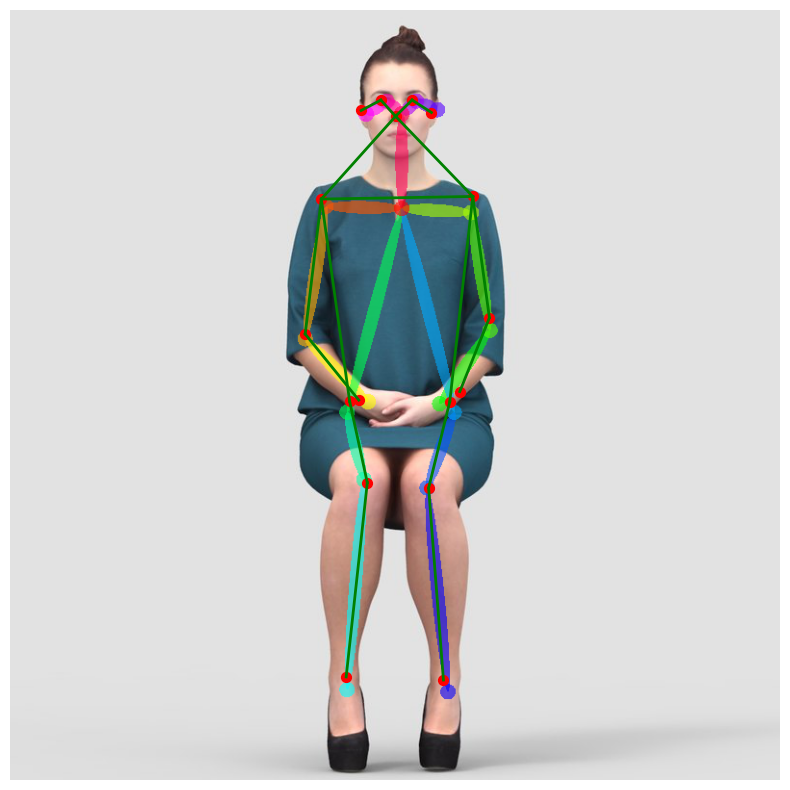

Final Prediction for 'Desktop/Fall Detection/Sitting/sit_0000003_r_.png': Sitting


In [198]:

# Function to preprocess the uploaded image
def preprocess_uploaded_image(image_path):
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not read image from {image_path}. Please check the file path.")
        return None, None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (192, 192))  # Resize to PoseNet's input size
    input_image = tf.image.convert_image_dtype(img_resized, dtype=tf.uint8)
    input_image = tf.expand_dims(input_image, axis=0)  # Add batch dimension
    input_image = tf.cast(input_image, dtype=tf.int32)  # Cast to int32
    return img_rgb, input_image

# Function to extract keypoints using PoseNet
def get_keypoints_posenet(input_image):
    movenet = model.signatures['serving_default']
    outputs = movenet(input_image)

    # Extract keypoints from the output tensor
    keypoints = outputs['output_0'][0].numpy().reshape(17, 3)  # Reshape to (17, 3)
    return keypoints

# Function to add distance features for classification
def add_features(keypoints):
    features = keypoints[:, :2].flatten().tolist()  # Flatten the keypoints (x, y)

    # Calculate distances between keypoints to add additional features
    def distance(p1, p2):
        return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

    # Add distances for consistent features
    features.append(distance(keypoints[5], keypoints[6]))  # Shoulders
    features.append(distance(keypoints[11], keypoints[12]))  # Hips

    return features

# Function to predict pose from the uploaded image
def predict_pose_from_uploaded_image(image_path):
    img_rgb, input_image = preprocess_uploaded_image(image_path)

    if img_rgb is None:
        return

    # Get keypoints using PoseNet
    keypoints = get_keypoints_posenet(input_image)

    # Create feature vector from keypoints and additional features
    feature_vector = add_features(keypoints)

    # Reshape to match the model input
    feature_vector = np.array(feature_vector).reshape(1, -1)

    # Ensure the feature vector matches the model's expected input size
    if feature_vector.shape[1] != rf_classifier.n_features_in_:
        print(f"Error: Feature vector has {feature_vector.shape[1]} features, but model expects {rf_classifier.n_features_in_} features.")
        return

    # Predict the pose using the trained Random Forest model
    prediction = rf_classifier.predict(feature_vector)[0]
    print(f"Predicted Pose: {prediction}")

    # Draw the skeleton on the image
    draw_skeleton_on_image(img_rgb, keypoints)
    return prediction

# Function to draw skeleton on the image
def draw_skeleton_on_image(image, keypoints, threshold=0.2):
    height, width, _ = image.shape

    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Define the skeleton structure
    skeleton = [
        (0, 1), (0, 2), (1, 3), (2, 4),  # Head and shoulders
        (0, 5), (0, 6), (5, 6),          # Upper torso
        (5, 7), (7, 9), (6, 8), (8, 10), # Arms
        (5, 11), (6, 12),                # Torso to hips
        (11, 13), (13, 15),              # Left leg
        (12, 14), (14, 16)               # Right leg
    ]

    # Plot keypoints
    for i, (y, x, confidence) in enumerate(keypoints):
        if confidence > threshold:
            plt.scatter(x * width, y * height, c='red', s=50)  # Draw keypoint

    # Plot skeleton
    for joint1, joint2 in skeleton:
        y1, x1, c1 = keypoints[joint1]
        y2, x2, c2 = keypoints[joint2]

        if c1 > threshold and c2 > threshold:
            plt.plot([x1 * width, x2 * width], [y1 * height, y2 * height], 'green', linewidth=2)  # Connect keypoints

    plt.axis('off')
    plt.show()

# Test with the uploaded image file
image_path = "Desktop/Fall Detection/Sitting/sit_0000003_r_.png" 
predicted_pose = predict_pose_from_uploaded_image(image_path)
print(f"Final Prediction for '{image_path}': {predicted_pose}")


Predicted Pose: Sitting


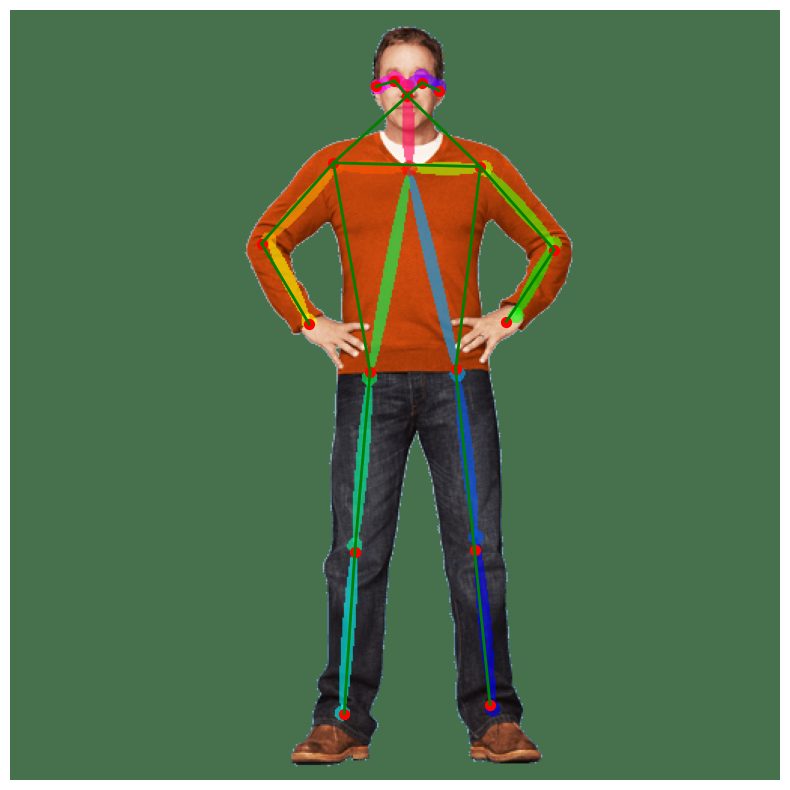

Final Prediction for 'Desktop/Fall Detection/Standing/stand_0000064_r_.png': Sitting


In [199]:
# Function to preprocess the uploaded image
def preprocess_uploaded_image(image_path):
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not read image from {image_path}. Please check the file path.")
        return None, None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (192, 192))  # Resize to PoseNet's input size
    input_image = tf.image.convert_image_dtype(img_resized, dtype=tf.uint8)
    input_image = tf.expand_dims(input_image, axis=0)  # Add batch dimension
    input_image = tf.cast(input_image, dtype=tf.int32)  # Cast to int32
    return img_rgb, input_image

# Function to extract keypoints using PoseNet
def get_keypoints_posenet(input_image):
    movenet = model.signatures['serving_default']
    outputs = movenet(input_image)

    # Extract keypoints from the output tensor
    keypoints = outputs['output_0'][0].numpy().reshape(17, 3)  # Reshape to (17, 3)
    return keypoints

# Function to add distance features for classification
def add_features(keypoints):
    features = keypoints[:, :2].flatten().tolist()  # Flatten the keypoints (x, y)

    # Calculate distances between keypoints to add additional features
    def distance(p1, p2):
        return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

    # Add distances for consistent features
    features.append(distance(keypoints[5], keypoints[6]))  # Shoulders
    features.append(distance(keypoints[11], keypoints[12]))  # Hips

    return features

# Function to predict pose from the uploaded image
def predict_pose_from_uploaded_image(image_path):
    img_rgb, input_image = preprocess_uploaded_image(image_path)

    if img_rgb is None:
        return

    # Get keypoints using PoseNet
    keypoints = get_keypoints_posenet(input_image)

    # Create feature vector from keypoints and additional features
    feature_vector = add_features(keypoints)

    # Reshape to match the model input
    feature_vector = np.array(feature_vector).reshape(1, -1)

    # Ensure the feature vector matches the model's expected input size
    if feature_vector.shape[1] != rf_classifier.n_features_in_:
        print(f"Error: Feature vector has {feature_vector.shape[1]} features, but model expects {rf_classifier.n_features_in_} features.")
        return

    # Predict the pose using the trained Random Forest model
    prediction = rf_classifier.predict(feature_vector)[0]
    print(f"Predicted Pose: {prediction}")

    # Draw the skeleton on the image
    draw_skeleton_on_image(img_rgb, keypoints)
    return prediction

# Function to draw skeleton on the image
def draw_skeleton_on_image(image, keypoints, threshold=0.2):
    height, width, _ = image.shape

    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Define the skeleton structure
    skeleton = [
        (0, 1), (0, 2), (1, 3), (2, 4),  # Head and shoulders
        (0, 5), (0, 6), (5, 6),          # Upper torso
        (5, 7), (7, 9), (6, 8), (8, 10), # Arms
        (5, 11), (6, 12),                # Torso to hips
        (11, 13), (13, 15),              # Left leg
        (12, 14), (14, 16)               # Right leg
    ]

    # Plot keypoints
    for i, (y, x, confidence) in enumerate(keypoints):
        if confidence > threshold:
            plt.scatter(x * width, y * height, c='red', s=50)  # Draw keypoint

    # Plot skeleton
    for joint1, joint2 in skeleton:
        y1, x1, c1 = keypoints[joint1]
        y2, x2, c2 = keypoints[joint2]

        if c1 > threshold and c2 > threshold:
            plt.plot([x1 * width, x2 * width], [y1 * height, y2 * height], 'green', linewidth=2)  # Connect keypoints

    plt.axis('off')
    plt.show()

# Test with the uploaded image file
image_path = "Desktop/Fall Detection/Standing/stand_0000064_r_.png"
predicted_pose = predict_pose_from_uploaded_image(image_path)
print(f"Final Prediction for '{image_path}': {predicted_pose}")


Predicted Pose: Lying Down


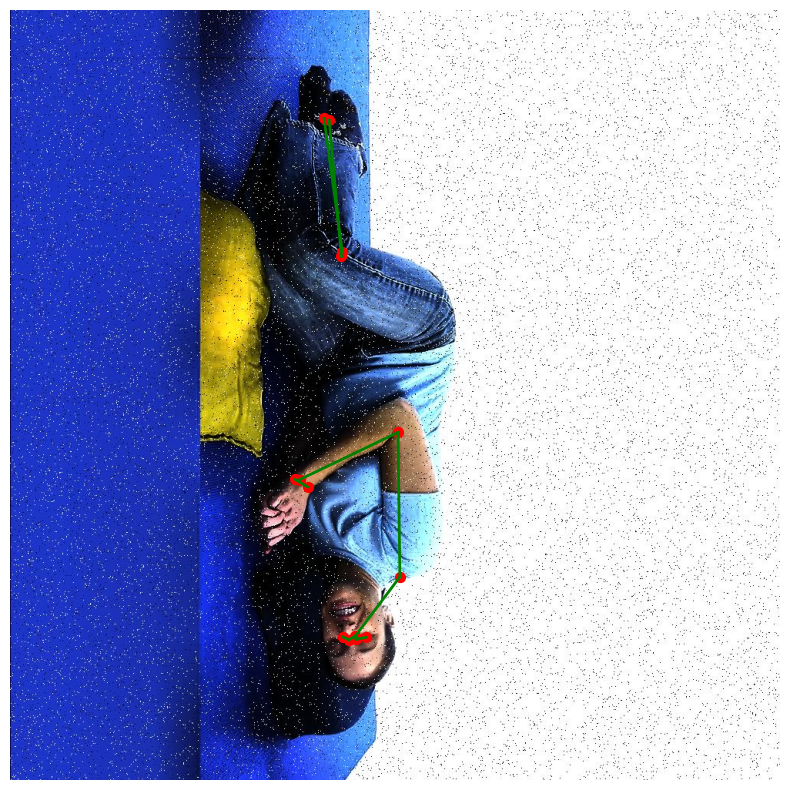

Final Prediction for 'Desktop/Fall Detection/Lying Down/91_jpg.rf.6ecd8d524c3f920d2cb5dd11f96fd9ed.jpg': Lying Down


In [200]:
# Function to preprocess the uploaded image
def preprocess_uploaded_image(image_path):
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not read image from {image_path}. Please check the file path.")
        return None, None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (192, 192))  # Resize to PoseNet's input size
    input_image = tf.image.convert_image_dtype(img_resized, dtype=tf.uint8)
    input_image = tf.expand_dims(input_image, axis=0)  # Add batch dimension
    input_image = tf.cast(input_image, dtype=tf.int32)  # Cast to int32
    return img_rgb, input_image

# Function to extract keypoints using PoseNet
def get_keypoints_posenet(input_image):
    movenet = model.signatures['serving_default']
    outputs = movenet(input_image)

    # Extract keypoints from the output tensor
    keypoints = outputs['output_0'][0].numpy().reshape(17, 3)  # Reshape to (17, 3)
    return keypoints

# Function to add distance features for classification
def add_features(keypoints):
    features = keypoints[:, :2].flatten().tolist()  # Flatten the keypoints (x, y)

    # Calculate distances between keypoints to add additional features
    def distance(p1, p2):
        return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

    # Add distances for consistent features
    features.append(distance(keypoints[5], keypoints[6]))  # Shoulders
    features.append(distance(keypoints[11], keypoints[12]))  # Hips

    return features

# Function to predict pose from the uploaded image
def predict_pose_from_uploaded_image(image_path):
    img_rgb, input_image = preprocess_uploaded_image(image_path)

    if img_rgb is None:
        return

    # Get keypoints using PoseNet
    keypoints = get_keypoints_posenet(input_image)

    # Create feature vector from keypoints and additional features
    feature_vector = add_features(keypoints)

    # Reshape to match the model input
    feature_vector = np.array(feature_vector).reshape(1, -1)

    # Ensure the feature vector matches the model's expected input size
    if feature_vector.shape[1] != rf_classifier.n_features_in_:
        print(f"Error: Feature vector has {feature_vector.shape[1]} features, but model expects {rf_classifier.n_features_in_} features.")
        return

    # Predict the pose using the trained Random Forest model
    prediction = rf_classifier.predict(feature_vector)[0]
    print(f"Predicted Pose: {prediction}")

    # Draw the skeleton on the image
    draw_skeleton_on_image(img_rgb, keypoints)
    return prediction

# Function to draw skeleton on the image
def draw_skeleton_on_image(image, keypoints, threshold=0.2):
    height, width, _ = image.shape

    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Define the skeleton structure
    skeleton = [
        (0, 1), (0, 2), (1, 3), (2, 4),  # Head and shoulders
        (0, 5), (0, 6), (5, 6),          # Upper torso
        (5, 7), (7, 9), (6, 8), (8, 10), # Arms
        (5, 11), (6, 12),                # Torso to hips
        (11, 13), (13, 15),              # Left leg
        (12, 14), (14, 16)               # Right leg
    ]

    # Plot keypoints
    for i, (y, x, confidence) in enumerate(keypoints):
        if confidence > threshold:
            plt.scatter(x * width, y * height, c='red', s=50)  # Draw keypoint

    # Plot skeleton
    for joint1, joint2 in skeleton:
        y1, x1, c1 = keypoints[joint1]
        y2, x2, c2 = keypoints[joint2]

        if c1 > threshold and c2 > threshold:
            plt.plot([x1 * width, x2 * width], [y1 * height, y2 * height], 'green', linewidth=2)  # Connect keypoints

    plt.axis('off')
    plt.show()

# Test with the uploaded image file
image_path = "Desktop/Fall Detection/Lying Down/91_jpg.rf.6ecd8d524c3f920d2cb5dd11f96fd9ed.jpg"
predicted_pose = predict_pose_from_uploaded_image(image_path)
print(f"Final Prediction for '{image_path}': {predicted_pose}")


# **Forward Neural Netowrk**

# **Pre Parameter Tuning**

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.4119 - loss: 1.1023 - val_accuracy: 0.4516 - val_loss: 1.0632
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3898 - loss: 1.1075 - val_accuracy: 0.5054 - val_loss: 1.0538
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4093 - loss: 1.0717 - val_accuracy: 0.5484 - val_loss: 1.0284
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4329 - loss: 1.0513 - val_accuracy: 0.5376 - val_loss: 1.0117
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4714 - loss: 1.0349 - val_accuracy: 0.5269 - val_loss: 0.9934
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4659 - loss: 1.0265 - val_accuracy: 0.5484 - val_loss: 0.9832
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5146 - loss: 1.0090 - val_accuracy: 0.5376 - val_loss: 0.9572
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5162 - loss: 0.9678 - val_accuracy: 0.5376 - va

C:\Users\61431\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\61431\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\61431\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


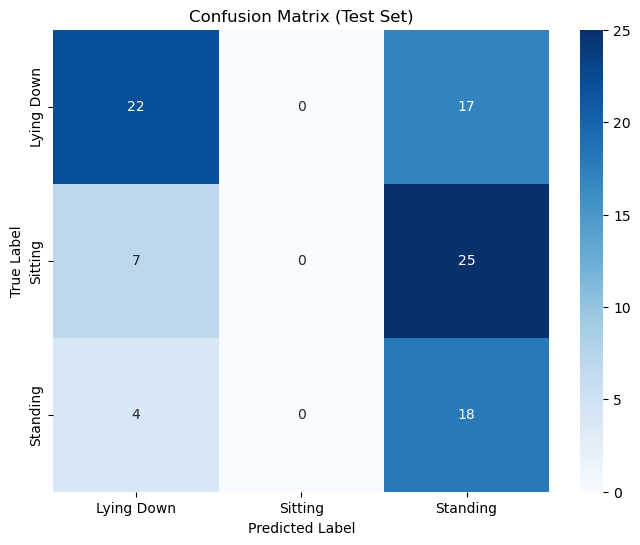

In [201]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# Load the dataset
file_path = "labeled_fall_detection_keypoints.xlsx"
df = pd.read_excel(file_path)

# Prepare feature vectors (X) and labels (y)
X = df[[f'Keypoint_{i}_x' for i in range(17)] + [f'Keypoint_{i}_y' for i in range(17)]].fillna(0).values
y = df['Label'].values

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Check the number of classes
num_classes = len(label_encoder.classes_)

# Build the neural network model
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Input layer
    Dense(64, activation='relu'),     # Hidden layer 1
    Dropout(0.5),                     # Dropout layer for regularization
    Dense(32, activation='relu'),     # Hidden layer 2
    Dropout(0.5),                     # Dropout layer for regularization
    Dense(num_classes, activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_labels = y_pred.argmax(axis=1)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred_labels)
print(f"\nTest Set Accuracy: {test_accuracy * 100:.2f}%")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()


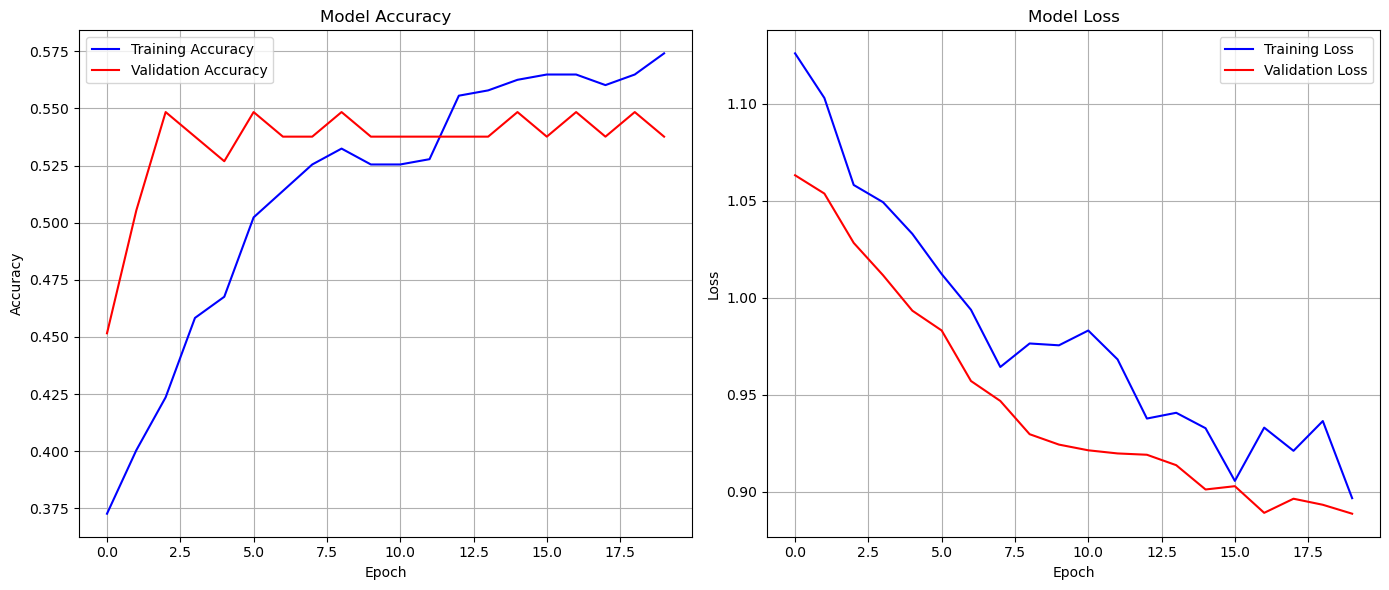

In [204]:

# Function to plot the learning curves for accuracy and loss
def plot_learning_curves(history):
    # Plot training & validation accuracy
    plt.figure(figsize=(14, 6))
    
    # Plot for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='b')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='r')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid(True)

    # Plot for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='b')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='r')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot the learning curves for the trained model
plot_learning_curves(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Pose: Lying Down


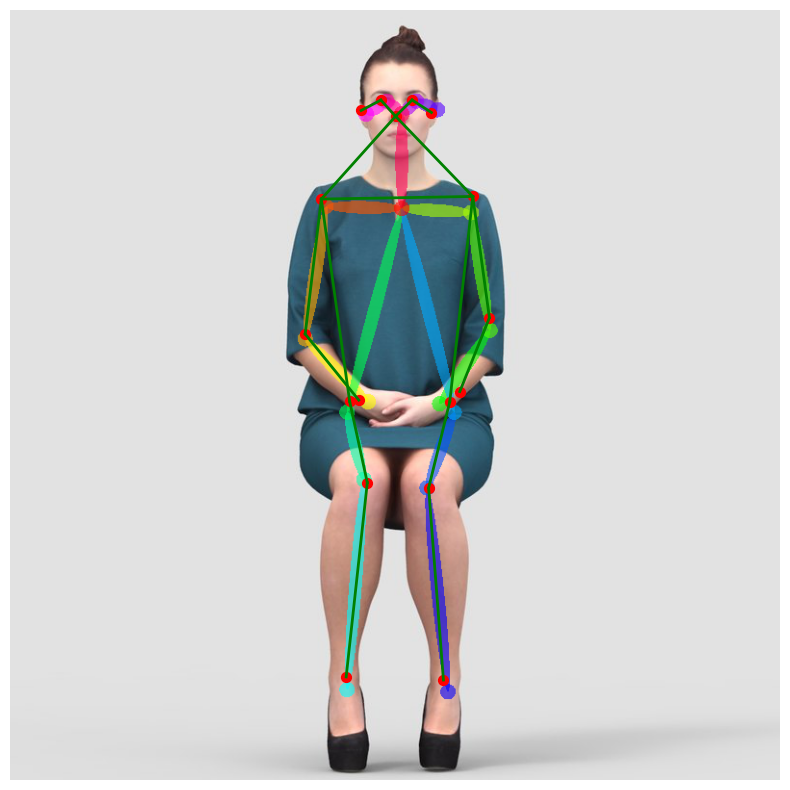

Final Prediction for 'Desktop/Fall Detection/Sitting/sit_0000003_r_.png': Lying Down


In [205]:
import cv2

import tensorflow as tf
import tensorflow_hub as hub

# Load the PoseNet model from TensorFlow Hub
posenet_model_url = "https://tfhub.dev/google/movenet/singlepose/lightning/4"
posenet_model = hub.load(posenet_model_url)

# Function to preprocess the uploaded image
def preprocess_uploaded_image(image_path):
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not read image from {image_path}. Please check the file path.")
        return None, None

    # Convert to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (192, 192))  # Resize to match PoseNet's input size

    # Prepare input image for PoseNet
    input_image = tf.image.convert_image_dtype(img_resized, dtype=tf.uint8)
    input_image = tf.expand_dims(input_image, axis=0)  # Add batch dimension
    input_image = tf.cast(input_image, dtype=tf.int32)  # Cast to int32
    return img_rgb, input_image

# Function to extract keypoints using PoseNet
def get_keypoints_posenet(input_image):
    movenet = posenet_model.signatures['serving_default']
    outputs = movenet(input_image)

    # Extract keypoints from the output tensor
    keypoints = outputs['output_0'][0].numpy().reshape(17, 3)  # Reshape to (17, 3)
    return keypoints

# Function to create a feature vector from keypoints (34 features)
def create_feature_vector(keypoints):
    # Flatten keypoints (only x and y coordinates)
    feature_vector = keypoints[:, :2].flatten().tolist()

    # Ensure the feature vector has 34 features (17 x-coordinates + 17 y-coordinates)
    if len(feature_vector) != 34:
        print(f"Error: Feature vector has {len(feature_vector)} features, expected 34 features.")
        return None

    return np.array(feature_vector).reshape(1, -1)  # Reshape for prediction

# Function to predict the class from the uploaded image
def predict_class_from_uploaded_image(image_path):
    img_rgb, input_image = preprocess_uploaded_image(image_path)

    if img_rgb is None:
        return

    # Get keypoints using PoseNet
    keypoints = get_keypoints_posenet(input_image)

    # Create a feature vector from keypoints
    feature_vector = create_feature_vector(keypoints)

    if feature_vector is None:
        return

    # Predict the class using the trained neural network model
    prediction = model.predict(feature_vector)
    predicted_class = prediction.argmax(axis=1)[0]

    # Get the predicted label from the label encoder
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    print(f"Predicted Pose: {predicted_label}")

    # Draw the skeleton on the image
    draw_skeleton_on_image(img_rgb, keypoints)
    return predicted_label

# Function to draw skeleton on the image
def draw_skeleton_on_image(image, keypoints, threshold=0.2):
    height, width, _ = image.shape

    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Define the skeleton structure
    skeleton = [
        (0, 1), (0, 2), (1, 3), (2, 4),  # Head and shoulders
        (0, 5), (0, 6), (5, 6),          # Upper torso
        (5, 7), (7, 9), (6, 8), (8, 10), # Arms
        (5, 11), (6, 12),                # Torso to hips
        (11, 13), (13, 15),              # Left leg
        (12, 14), (14, 16)               # Right leg
    ]

    # Plot keypoints
    for i, (y, x, confidence) in enumerate(keypoints):
        if confidence > threshold:
            plt.scatter(x * width, y * height, c='red', s=50)  # Draw keypoint

    # Plot skeleton
    for joint1, joint2 in skeleton:
        y1, x1, c1 = keypoints[joint1]
        y2, x2, c2 = keypoints[joint2]

        if c1 > threshold and c2 > threshold:
            plt.plot([x1 * width, x2 * width], [y1 * height, y2 * height], 'green', linewidth=2)  # Connect keypoints

    plt.axis('off')
    plt.show()

# Test with the uploaded image file
image_path = "Desktop/Fall Detection/Sitting/sit_0000003_r_.png"  
predicted_pose = predict_class_from_uploaded_image(image_path)
print(f"Final Prediction for '{image_path}': {predicted_pose}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predicted Pose: Lying Down


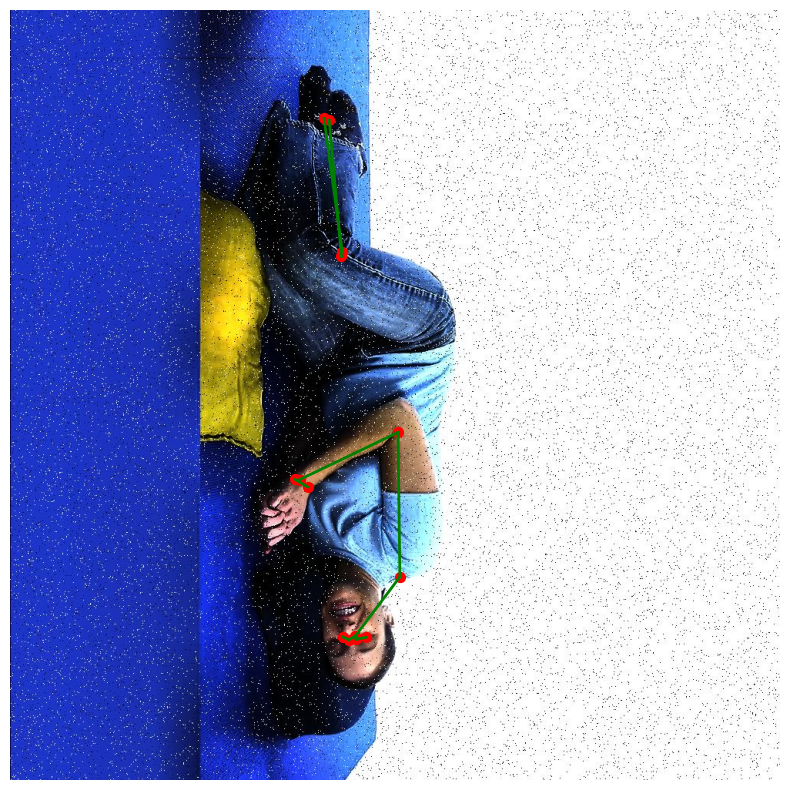

Final Prediction for 'Desktop/Fall Detection/Lying Down/91_jpg.rf.6ecd8d524c3f920d2cb5dd11f96fd9ed.jpg': Lying Down


In [206]:
# Function to preprocess the uploaded image
def preprocess_uploaded_image(image_path):
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not read image from {image_path}. Please check the file path.")
        return None, None

    # Convert to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (192, 192))  # Resize to match PoseNet's input size

    # Prepare input image for PoseNet
    input_image = tf.image.convert_image_dtype(img_resized, dtype=tf.uint8)
    input_image = tf.expand_dims(input_image, axis=0)  # Add batch dimension
    input_image = tf.cast(input_image, dtype=tf.int32)  # Cast to int32
    return img_rgb, input_image

# Function to extract keypoints using PoseNet
def get_keypoints_posenet(input_image):
    movenet = posenet_model.signatures['serving_default']
    outputs = movenet(input_image)

    # Extract keypoints from the output tensor
    keypoints = outputs['output_0'][0].numpy().reshape(17, 3)  # Reshape to (17, 3)
    return keypoints

# Function to create a feature vector from keypoints (34 features)
def create_feature_vector(keypoints):
    # Flatten keypoints (only x and y coordinates)
    feature_vector = keypoints[:, :2].flatten().tolist()

    # Ensure the feature vector has 34 features (17 x-coordinates + 17 y-coordinates)
    if len(feature_vector) != 34:
        print(f"Error: Feature vector has {len(feature_vector)} features, expected 34 features.")
        return None

    return np.array(feature_vector).reshape(1, -1)  # Reshape for prediction

# Function to predict the class from the uploaded image
def predict_class_from_uploaded_image(image_path):
    img_rgb, input_image = preprocess_uploaded_image(image_path)

    if img_rgb is None:
        return

    # Get keypoints using PoseNet
    keypoints = get_keypoints_posenet(input_image)

    # Create a feature vector from keypoints
    feature_vector = create_feature_vector(keypoints)

    if feature_vector is None:
        return

    # Predict the class using the trained neural network model
    prediction = model.predict(feature_vector)
    predicted_class = prediction.argmax(axis=1)[0]

    # Get the predicted label from the label encoder
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    print(f"Predicted Pose: {predicted_label}")

    # Draw the skeleton on the image
    draw_skeleton_on_image(img_rgb, keypoints)
    return predicted_label

# Function to draw skeleton on the image
def draw_skeleton_on_image(image, keypoints, threshold=0.2):
    height, width, _ = image.shape

    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Define the skeleton structure
    skeleton = [
        (0, 1), (0, 2), (1, 3), (2, 4),  # Head and shoulders
        (0, 5), (0, 6), (5, 6),          # Upper torso
        (5, 7), (7, 9), (6, 8), (8, 10), # Arms
        (5, 11), (6, 12),                # Torso to hips
        (11, 13), (13, 15),              # Left leg
        (12, 14), (14, 16)               # Right leg
    ]

    # Plot keypoints
    for i, (y, x, confidence) in enumerate(keypoints):
        if confidence > threshold:
            plt.scatter(x * width, y * height, c='red', s=50)  # Draw keypoint

    # Plot skeleton
    for joint1, joint2 in skeleton:
        y1, x1, c1 = keypoints[joint1]
        y2, x2, c2 = keypoints[joint2]

        if c1 > threshold and c2 > threshold:
            plt.plot([x1 * width, x2 * width], [y1 * height, y2 * height], 'green', linewidth=2)  # Connect keypoints

    plt.axis('off')
    plt.show()

# Test with the uploaded image file
image_path = "Desktop/Fall Detection/Lying Down/91_jpg.rf.6ecd8d524c3f920d2cb5dd11f96fd9ed.jpg"  
predicted_pose = predict_class_from_uploaded_image(image_path)
print(f"Final Prediction for '{image_path}': {predicted_pose}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted Pose: Lying Down


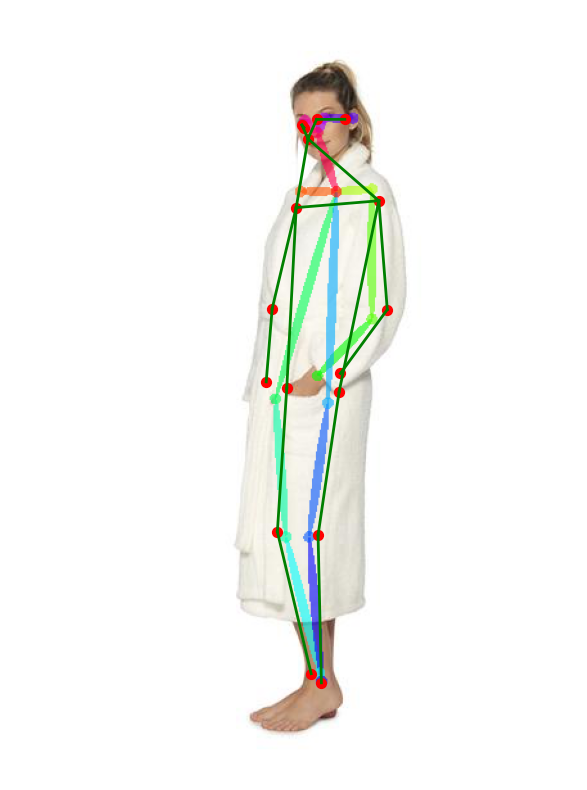

Final Prediction for 'Desktop/Fall Detection/Standing/stand_0000097_r_.png': Lying Down


In [207]:
# Function to preprocess the uploaded image
def preprocess_uploaded_image(image_path):
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not read image from {image_path}. Please check the file path.")
        return None, None

    # Convert to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (192, 192))  # Resize to match PoseNet's input size

    # Prepare input image for PoseNet
    input_image = tf.image.convert_image_dtype(img_resized, dtype=tf.uint8)
    input_image = tf.expand_dims(input_image, axis=0)  # Add batch dimension
    input_image = tf.cast(input_image, dtype=tf.int32)  # Cast to int32
    return img_rgb, input_image

# Function to extract keypoints using PoseNet
def get_keypoints_posenet(input_image):
    movenet = posenet_model.signatures['serving_default']
    outputs = movenet(input_image)

    # Extract keypoints from the output tensor
    keypoints = outputs['output_0'][0].numpy().reshape(17, 3)  # Reshape to (17, 3)
    return keypoints

# Function to create a feature vector from keypoints (34 features)
def create_feature_vector(keypoints):
    # Flatten keypoints (only x and y coordinates)
    feature_vector = keypoints[:, :2].flatten().tolist()

    # Ensure the feature vector has 34 features (17 x-coordinates + 17 y-coordinates)
    if len(feature_vector) != 34:
        print(f"Error: Feature vector has {len(feature_vector)} features, expected 34 features.")
        return None

    return np.array(feature_vector).reshape(1, -1)  # Reshape for prediction

# Function to predict the class from the uploaded image
def predict_class_from_uploaded_image(image_path):
    img_rgb, input_image = preprocess_uploaded_image(image_path)

    if img_rgb is None:
        return

    # Get keypoints using PoseNet
    keypoints = get_keypoints_posenet(input_image)

    # Create a feature vector from keypoints
    feature_vector = create_feature_vector(keypoints)

    if feature_vector is None:
        return

    # Predict the class using the trained neural network model
    prediction = model.predict(feature_vector)
    predicted_class = prediction.argmax(axis=1)[0]

    # Get the predicted label from the label encoder
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    print(f"Predicted Pose: {predicted_label}")

    # Draw the skeleton on the image
    draw_skeleton_on_image(img_rgb, keypoints)
    return predicted_label

# Function to draw skeleton on the image
def draw_skeleton_on_image(image, keypoints, threshold=0.2):
    height, width, _ = image.shape

    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Define the skeleton structure
    skeleton = [
        (0, 1), (0, 2), (1, 3), (2, 4),  # Head and shoulders
        (0, 5), (0, 6), (5, 6),          # Upper torso
        (5, 7), (7, 9), (6, 8), (8, 10), # Arms
        (5, 11), (6, 12),                # Torso to hips
        (11, 13), (13, 15),              # Left leg
        (12, 14), (14, 16)               # Right leg
    ]

    # Plot keypoints
    for i, (y, x, confidence) in enumerate(keypoints):
        if confidence > threshold:
            plt.scatter(x * width, y * height, c='red', s=50)  # Draw keypoint

    # Plot skeleton
    for joint1, joint2 in skeleton:
        y1, x1, c1 = keypoints[joint1]
        y2, x2, c2 = keypoints[joint2]

        if c1 > threshold and c2 > threshold:
            plt.plot([x1 * width, x2 * width], [y1 * height, y2 * height], 'green', linewidth=2)  # Connect keypoints

    plt.axis('off')
    plt.show()

# Test with the uploaded image file
image_path =  "Desktop/Fall Detection/Standing/stand_0000097_r_.png"  
predicted_pose = predict_class_from_uploaded_image(image_path)
print(f"Final Prediction for '{image_path}': {predicted_pose}")




# **Post Parameter Tuning**

C:\Users\61431\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Hyperparameters: {'batch_size': 16, 'epochs': 20, 'model__dropout_rate': 0.3, 'model__num_neurons': 128, 'model__optimizer': 'adam'}

Test Set Accuracy after GridSearch: 67.74%

Classification Report:
              precision    recall  f1-score   support

  Lying Down       0.89      0.72      0.80        46
     Sitting       0.56      0.71      0.63        38
    Standing       0.62      0.60      0.61        40

    accuracy                           0.68       124
   macro avg       0.69      0.68      0.68       124
weighted avg       0.70      0.68      0.68       124



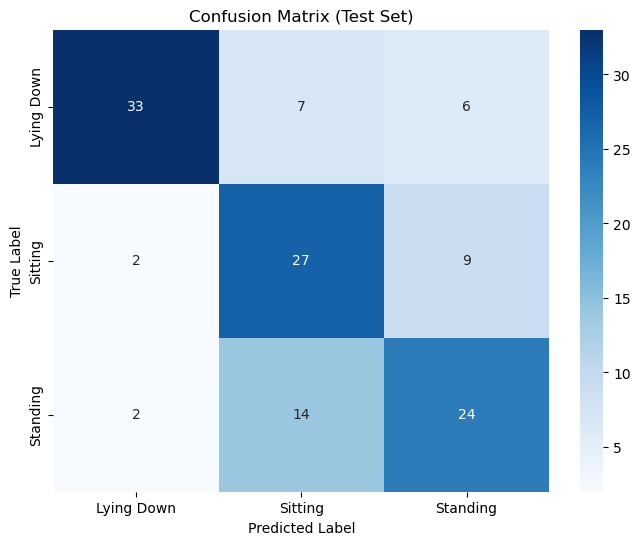

In [209]:
from scikeras.wrappers import KerasClassifier

# Load the dataset
file_path = "labeled_fall_detection_keypoints.xlsx"
df = pd.read_excel(file_path)

# Prepare feature vectors (X) and labels (y)
X = df[[f'Keypoint_{i}_x' for i in range(17)] + [f'Keypoint_{i}_y' for i in range(17)]].fillna(0).values
y = df['Label'].values

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Function to create the model
def create_model(optimizer='adam', dropout_rate=0.5, num_neurons=64):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),  # Input layer
        Dense(num_neurons, activation='relu'),  # Hidden layer
        Dropout(dropout_rate),  # Dropout layer
        Dense(num_neurons // 2, activation='relu'),  # Hidden layer
        Dropout(dropout_rate),  # Dropout layer
        Dense(len(np.unique(y_encoded)), activation='softmax')  # Output layer
    ])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model using KerasClassifier from scikeras
model = KerasClassifier(
    model=create_model,
    optimizer='adam',
    dropout_rate=0.5,
    num_neurons=64,
    batch_size=32,
    epochs=10,
    verbose=0
)

# Define the parameter grid for GridSearch
param_grid = {
    'model__optimizer': ['adam', 'rmsprop'],
    'model__dropout_rate': [0.3, 0.5],
    'model__num_neurons': [32, 64, 128],
    'batch_size': [16, 32],
    'epochs': [10, 20]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')

# Fit GridSearchCV
grid_result = grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_result.best_estimator_

# Display the best hyperparameters
print(f"Best Hyperparameters: {grid_result.best_params_}")

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy after GridSearch: {test_accuracy * 100:.2f}%")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()


Predicted Pose: Lying Down


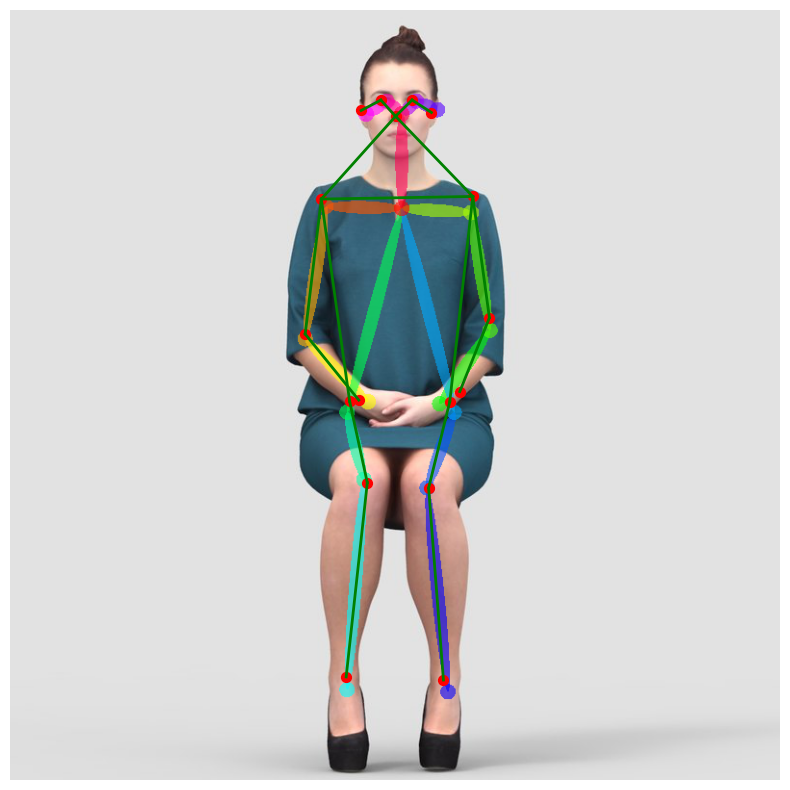

Final Prediction for 'Desktop/Fall Detection/Sitting/sit_0000003_r_.png': Lying Down


In [213]:
# Function to predict the class from the uploaded image using the tuned model
def predict_class_from_uploaded_image(image_path):
    img_rgb, input_image = preprocess_uploaded_image(image_path)

    if img_rgb is None:
        return

    # Get keypoints using PoseNet
    keypoints = get_keypoints_posenet(input_image)

    # Create a feature vector from keypoints
    feature_vector = create_feature_vector(keypoints)

    if feature_vector is None:
        return

    # Predict the class using the tuned neural network model
    prediction = best_model.predict(feature_vector)

    # Extract the predicted class from the output
    if prediction.ndim == 1:  # If the output is 1D
        predicted_class = prediction.argmax()
    else:  # If the output is 2D
        predicted_class = prediction.argmax(axis=1)[0]

    # Get the predicted label from the label encoder
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    print(f"Predicted Pose: {predicted_label}")

    # Draw the skeleton on the image
    draw_skeleton_on_image(img_rgb, keypoints)
    return predicted_label

# Test with the uploaded image file
image_path = "Desktop/Fall Detection/Sitting/sit_0000003_r_.png"  # Replace with your image path
predicted_pose = predict_class_from_uploaded_image(image_path)
print(f"Final Prediction for '{image_path}': {predicted_pose}")




Predicted Pose: Lying Down


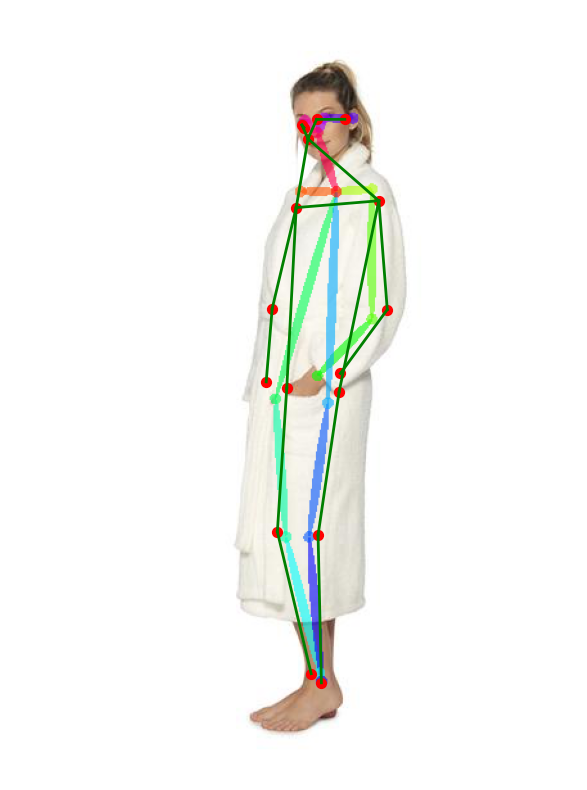

Final Prediction for 'Desktop/Fall Detection/Standing/stand_0000097_r_.png': Lying Down


In [215]:
# Function to predict the class from the uploaded image using the tuned model
def predict_class_from_uploaded_image(image_path):
    img_rgb, input_image = preprocess_uploaded_image(image_path)

    if img_rgb is None:
        return

    # Get keypoints using PoseNet
    keypoints = get_keypoints_posenet(input_image)

    # Create a feature vector from keypoints
    feature_vector = create_feature_vector(keypoints)

    if feature_vector is None:
        return

    # Predict the class using the tuned neural network model
    prediction = best_model.predict(feature_vector)

    # Extract the predicted class from the output
    if prediction.ndim == 1:  # If the output is 1D
        predicted_class = prediction.argmax()
    else:  # If the output is 2D
        predicted_class = prediction.argmax(axis=1)[0]

    # Get the predicted label from the label encoder
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    print(f"Predicted Pose: {predicted_label}")

    # Draw the skeleton on the image
    draw_skeleton_on_image(img_rgb, keypoints)
    return predicted_label

# Test with the uploaded image file
image_path = "Desktop/Fall Detection/Standing/stand_0000097_r_.png"   # Replace with your image path
predicted_pose = predict_class_from_uploaded_image(image_path)
print(f"Final Prediction for '{image_path}': {predicted_pose}")


Predicted Pose: Lying Down


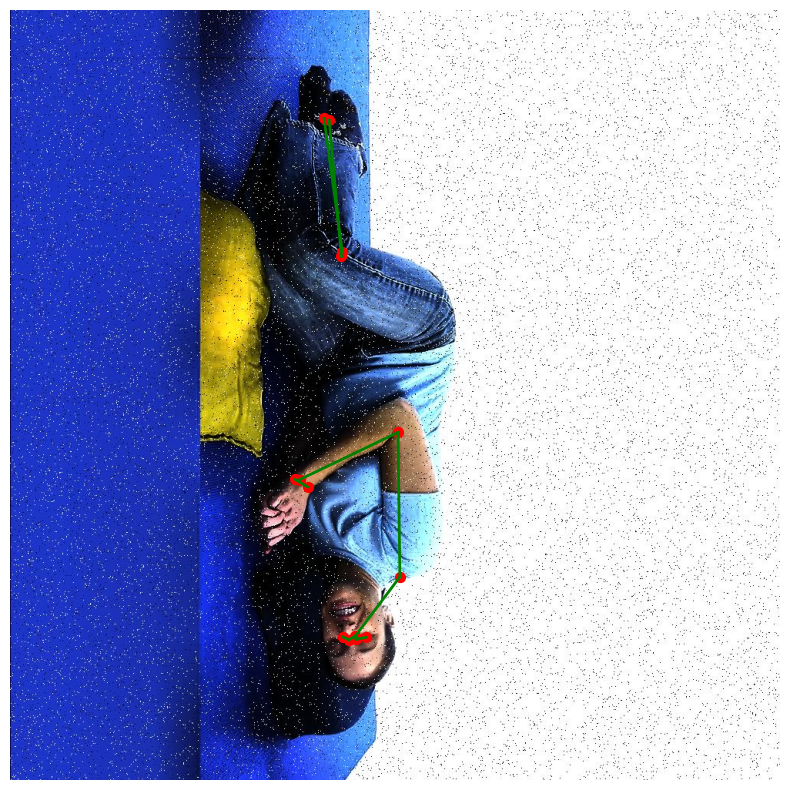

Final Prediction for 'Desktop/Fall Detection/Lying Down/91_jpg.rf.6ecd8d524c3f920d2cb5dd11f96fd9ed.jpg': Lying Down


In [217]:
# Function to predict the class from the uploaded image using the tuned model
def predict_class_from_uploaded_image(image_path):
    img_rgb, input_image = preprocess_uploaded_image(image_path)

    if img_rgb is None:
        return

    # Get keypoints using PoseNet
    keypoints = get_keypoints_posenet(input_image)

    # Create a feature vector from keypoints
    feature_vector = create_feature_vector(keypoints)

    if feature_vector is None:
        return

    # Predict the class using the tuned neural network model
    prediction = best_model.predict(feature_vector)

    # Extract the predicted class from the output
    if prediction.ndim == 1:  # If the output is 1D
        predicted_class = prediction.argmax()
    else:  # If the output is 2D
        predicted_class = prediction.argmax(axis=1)[0]

    # Get the predicted label from the label encoder
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    print(f"Predicted Pose: {predicted_label}")

    # Draw the skeleton on the image
    draw_skeleton_on_image(img_rgb, keypoints)
    return predicted_label

# Test with the uploaded image file
image_path = "Desktop/Fall Detection/Lying Down/91_jpg.rf.6ecd8d524c3f920d2cb5dd11f96fd9ed.jpg"   # Replace with your image path
predicted_pose = predict_class_from_uploaded_image(image_path)
print(f"Final Prediction for '{image_path}': {predicted_pose}")
